# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [13]:
file_k200 = 'kospi200_prices_240710.csv'
file_etf = 'etfs_all_240710.csv'
download = False

## KOSPI200

In [14]:
k200 = DataManager(
    file = file_k200,
    universe = 'KOSPI200',
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [15]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [16]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [17]:
etf = DataManager(
    file = file_etf,
    universe = 'ETF',
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [18]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [19]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

# Backtest

## testing

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import FinanceDataReader as fdr
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import os, time, re, sys
from datetime import datetime, timedelta
from contextlib import contextmanager

import bt
from pf_custom import AlgoSelectKRatio, calc_kratio

import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

# support korean lang
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'

metrics = [
    'total_return', 'cagr', 'calmar', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_vol', 'daily_sharpe', 'daily_sortino', 
    'monthly_vol', 'monthly_sharpe', 'monthly_sortino'
]

WEEKS_IN_YEAR = 51


def import_rate1(file, path='.', cols=['date', None]):
    """
    file: historical of cumulative rate of return in long format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=[0])
    if df_rate.columns.size > 1:
        print('WARNING: taking the 1st two columns only.')
    # make sure to get series
    df_rate = df_rate.iloc[:, 0]
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate


def import_rate2(file, path='.', cols=['date', None], n_headers=1):
    """
    file: historical of cumulative rate of return in wide format
    data_check: [(기준일1, 기준가1), (기준일2, 기준가2)]
    """
    df_rate = pd.read_csv(f'{path}/{file}')
    df_rate = df_rate.T.iloc[n_headers:, 0]

    df_rate.index = pd.to_datetime(df_rate.index)
    df_rate = df_rate.rename_axis(cols[0])
    
    col_data = cols[1]
    if col_data is None:
        col_data = file.split('.')[0]
    df_rate.name = col_data

    return df_rate
    

def get_price(df_rate, data_check, rate_is_percent=True):
    """
    calc price from rate of return
    """
    # date check
    for dt, _ in data_check:
        try:
            dt = pd.to_datetime(dt)
            rate = df_rate.loc[dt]
        except KeyError as e:
            return print(f'ERROR: KeyError {e}')
    
    # convert to price with data_check[0]
    dt, price = data_check[0]
    dt = pd.to_datetime(dt)
    rate = df_rate.loc[dt]
    if rate_is_percent:
        rate = rate/100
        df_rate = df_rate/100
    price_base = price / (rate+1)
    df_price = (df_rate + 1) * price_base 

    # check price
    dt, price = data_check[1]
    e = df_price.loc[dt]/price - 1
    print(f'error: {e*100:.2f} %')
    
    return df_price


def convert_rate_to_price(data, n_headers=1, path=None, 
                          rate_is_percent=True, df_rate=None, rate_only=False):
    """
    data: series or dict
    df_rate: historical given as dataframe
    """
    data_type = data['data_type']
    if data_type == 1:
        import_rate = import_rate1
    elif data_type == 2:
        import_rate = lambda *args, **kwargs: import_rate2(*args, n_headers=n_headers, **kwargs)
    else:
        if df_rate is None:
            return print(f'ERROR: no data type {data_type} exists')
        else:
            import_rate = lambda *args, **kwargs: df_rate.rename_axis(kwargs['cols'][0]).rename(kwargs['cols'][1])
    
    ticker = data['ticker']
    name = data['name']
    file = f'{data['file']}.csv'
    data_check = [
        (data['check1_date'], data['check1_price']),
        (data['check2_date'], data['check2_price']),
    ]
    
    df = import_rate(file, path=path, cols=['date', ticker])
    if rate_only:
       return df
        
    df = get_price(df, data_check, rate_is_percent=rate_is_percent)
    if df is None:
        return print(f'ERROR: check {ticker}')
    else:
        return df


def get_date_range(dfs, symbol_name=None, return_intersection=False):
    """
    get datetime range of each ticker (columns) or datetime index of intersection
    dfs: index date, columns tickers
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    df = df.join(dfs.apply(lambda x: x[x.notna()].index.max()).to_frame('end date'))
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)

    if return_intersection:
        start_date = df.iloc[:, 0].max()
        end_date = df.iloc[:, 1].min()
        return dfs.loc[start_date:end_date]
    else:
        return df.sort_values('start date')



def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)


def check_days_in_year(df, days_in_year=252, freq='M', n_thr=10):
    """
    freq: unit to check days_in_year in df
    """
    if freq == 'Y':
        grp_format = '%Y'
        #days_in_freq = days_in_year
        factor = 1
    elif freq == 'W':
        grp_format = '%Y%m%U'
        #days_in_freq = round(days_in_year/12/WEEKS_IN_YEAR)
        factor = 12 * WEEKS_IN_YEAR
    else: # default month
        grp_format = '%Y%m'
        #days_in_freq = round(days_in_year/12)
        factor = 12

    # calc mean days for each asset
    df_days = (df.assign(gb=df.index.strftime(grp_format)).set_index('gb')
                 .apply(lambda x: x.dropna().groupby('gb').count()[1:-1])
                 .mul(factor).mean().round())

    cond = (df_days != days_in_year)
    if cond.sum() > 0:
        df = df_days.loc[cond]
        n = len(df)
        if n < n_thr:
            #print(f'WARNING: the number of days in a year with followings is not {days_in_year} in setting:')
            print(f'WARNING: the number of days in a year with followings is {df.mean()} in avg.:')
            _ = [print(f'{k}: {int(v)}') for k,v in df.to_dict().items()]
        else:
            p = n / len(df_days) * 100
            #print(f'WARNING: the number of days in a year with {n} assets ({p:.0f}%) is not {days_in_year} in setting:')
            print(f'WARNING: the number of days in a year with {n} assets ({p:.0f}%) is {df.mean()} in avg.')
    
    return df_days


def align_period(df_assets, axis=0, date_format='%Y-%m-%d',
                 fill_na=True, print_msg1=True, print_msg2=True, n_indent=2):
    """
    axis: Determines the operation for handling missing data.
        0 : Drop rows (time index) with missing prices.
        1 : Drop columns (assets) with a count of non-missing prices less than the maximum found.
    fill_na: set False to drop nan fields
    """
    msg1 = None
    if axis == 0:
        df_aligned = get_date_range(df_assets, return_intersection=True)
        if len(df_aligned) < len(df_assets):
            dts = [x.strftime(date_format) for x in (df_aligned.index.min(), df_aligned.index.max())]
            msg1 = f"period reset: {' ~ '.join(dts)}"
    elif axis == 1:
        c_all = df_assets.columns
        df_cnt = df_assets.apply(lambda x: x.dropna().count())
        cond = (df_cnt < df_cnt.max())
        c_drop = c_all[cond]
        df_aligned = df_assets[c_all.difference(c_drop)]
        n_c = len(c_drop)
        if n_c > 0:
            n_all = len(c_all)
            msg1 = f'{n_c} assets removed for shorter periods ({n_c/n_all*100:.1f}%)'
    else:
        pass

    if print_msg1:
        print(msg1) if msg1 is not None else None
        if print_msg2:
            stats = df_aligned.isna().sum().div(df_aligned.count())
            t = 'filled forward' if fill_na else 'dropped'
            print(f'ratio of nan {t}::')
            indent = ' '*n_indent
            _ = [print(f'{indent}{i}: {stats[i]:.3f}') for i in stats.index]

    if fill_na:
        return df_aligned.ffill()
    else:
        return df_aligned.dropna()


def print_runtime(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time of {func.__name__}: {end_time - start_time:.2f} secs")
        return result
    return wrapper


class AssetDict(dict):
    """
    A dictionary subclass that associates keys (ex:asset tickers) with names.
    Attributes:
        names (dict): Optional dictionary mapping tickers to names.
    """
    def __init__(self, *args, names=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.names = names

    def __repr__(self):
        output = ""
        for i, key in enumerate(self.keys()):
            name = self.get_name(key)
            if name is None:
                output += f"{i}) {key}\n"
            else:
                output += f"{i}) {key}: {name}\n"
        return output

    def get_name(self, key):
        if self.names is None:
            return None
        else:
            try:
                return self.names[key]
            except KeyError:
                return None


class IndentOutput:
    def __init__(self, indent=4):
        self.indent = ' ' * indent
        self.old_target = sys.stdout
    
    def write(self, text):
        if text.strip():  # Only indent non-empty lines
            indented_text = f"{self.indent}{text.replace('\n', f'\n{self.indent}')}"
            self.old_target.write(indented_text)
        else:
            self.old_target.write(text)
    
    def flush(self):
        pass  # This method is needed to match the interface of sys.stdout

    @contextmanager
    def indented_output(self):
        old_stdout = sys.stdout
        sys.stdout = self
        try:
            yield
        finally:
            sys.stdout = old_stdout

### class

In [21]:
class BacktestManager():
    def __init__(self, df_assets, name_prfx='Portfolio',
                 align_axis=0, fill_na=True, metrics=metrics,  
                 initial_capital=1000000, commissions=None, 
                 days_in_year=252, asset_names=None):
        """
        align_axis: how to set time periods intersection with assets
        fill_na: fill forward na in df_assets if True, drop na if False 
        """
        # df of assets (assets in columns) which of each has its own periods.
        # the periods will be aligned for assets in a portfolio. see self.build
        if isinstance(df_assets, pd.Series):
            return print('ERROR: df_assets must be Dataframe')
        
        df_assets = self.align_period(df_assets, axis=align_axis, fill_na=fill_na, print_msg2=False)
        self.df_assets = df_assets
        self.portfolios = AssetDict(names=asset_names) # dict of bt.backtest.Backtest
        self.cv_strategies = AssetDict(names=asset_names) # dict of args of strategies to cross-validate
        self.metrics = metrics
        self.name_prfx = name_prfx
        self.n_names = 0 # see self._check_name
        self.initial_capital = initial_capital
        # commissions of all assets across portfolios
        self.commissions = commissions  # unit %
        self.run_results = None
        self.days_in_year = days_in_year # only for self._get_algo_freq
        # saving to apply the same rule in benchmark data
        self.align_axis = align_axis
        self.fill_na = fill_na
        self.asset_names = asset_names
        self.print_algos_msg = True # control msg print in self._get_algo_*

        # run after set self.df_assets
        print('running self.util_check_days_in_year to check days in a year')
        _ = self.util_check_days_in_year(df_assets, days_in_year, freq='M')


    def align_period(self, df_assets, axis=0, date_format='%Y-%m-%d',
                     fill_na=True, print_msg1=True, print_msg2=True, n_indent=2):
        return align_period(df_assets, axis=axis, date_format=date_format,
                     fill_na=fill_na, print_msg1=print_msg1, print_msg2=print_msg2, n_indent=n_indent)


    def _check_name(self, name=None):
        if name is None:
            self.n_names += 1
            name = f'{self.name_prfx}{self.n_names}'
        return name

    
    def _check_var(self, var_arg, var_self):
        if var_arg is None:
            var_arg = var_self
        return var_arg


    def _check_weights(self, weights, dfs):
        """
        weights: str, list of str, dict, or None
        """
        if isinstance(weights, str):
            if weights in dfs.columns:
                return {weights: 1}
            else:
                return print(f'ERROR: No {weights} in the dfs')
        elif isinstance(weights, list):
            cols = pd.Index(weights).difference(dfs.columns)
            if len(cols) == 0:
                return {k:1/len(weights) for k in weights}
            else:
                cols = ', '.join(cols)
                return print(f'ERROR: No {cols} in the dfs')
        else: # assuming dict
            return weights


    def _check_algos(self, select, freq, weigh):
        cond = lambda x,y: False if x is None else x.lower() == y.lower()
        # managed to make it work
        if cond(select['select'], 'randomly') and cond(weigh['weigh'], 'ERC'):
            #return print('WARNING: random select does not work with ERC weighting')
            return None
        else:
            return None
    

    def backtest(self, dfs, name='portfolio', 
                 select={'select':'all'}, freq={'freq':'year'}, weigh={'weigh':'equally'},
                 algos=None, commissions=None, **kwargs):
        """
        kwargs: keyword args for bt.Backtest except commissions
        algos: List of Algos
        """
        _ = self._check_algos(select, freq, weigh)
        if algos is None:
            algos = [
                self._get_algo_select(**select), 
                self._get_algo_freq(**freq), 
                self._get_algo_weigh(**weigh),
                bt.algos.Rebalance()
            ]
        strategy = bt.Strategy(name, algos)
        if commissions is not None:
            c = lambda q, p: abs(q) * p * commissions
        return bt.Backtest(strategy, dfs, commissions=c, **kwargs)


    def _get_algo_select(self, select='all', n_assets=0, lookback=0, lag=0):
        """
        select: all, momentum, kratio, randomly
        """
        cond = lambda x,y: False if x is None else x.lower() == y.lower()
        
        if cond(select, 'Momentum'):
            algo_select = bt.algos.SelectMomentum(n=n_assets, lookback=pd.DateOffset(months=lookback),
                                                  lag=pd.DateOffset(days=lag))
            # SelectAll() or similar should be called before SelectMomentum(), 
            # as StatTotalReturn uses values of temp[‘selected’]
            algo_select = bt.AlgoStack(bt.algos.SelectAll(), algo_select)
        elif cond(select, 'k-ratio'):
            algo_select = AlgoSelectKRatio(n=n_assets, lookback=pd.DateOffset(months=lookback),
                                       lag=pd.DateOffset(days=lag))
            algo_select = bt.AlgoStack(bt.algos.SelectAll(), algo_select)
        elif cond(select, 'randomly'):
            algo_after = AlgoRunAfter(lookback=pd.DateOffset(months=lookback), 
                                      lag=pd.DateOffset(days=lag))
            algo_select = bt.algos.SelectRandomly(n=n_assets)
            algo_select = bt.AlgoStack(algo_after, bt.algos.SelectAll(), algo_select)
        else:
            algo_after = AlgoRunAfter(lookback=pd.DateOffset(months=lookback), 
                                      lag=pd.DateOffset(days=lag))
            algo_select = bt.AlgoStack(algo_after, bt.algos.SelectAll())
            if not cond(select, 'all'):
                print('SelectAll selected') if self.print_algos_msg else None
          
        return algo_select
        

    def _get_algo_freq(self, freq='M', offset=0, days_in_year=252):
        """
        freq: W, M, Q, Y, or num of days
        """
        if isinstance(freq, int):
            n = freq
        else:
            cond = lambda x, y: False if x is None else x[0].lower() == y[0].lower()
            if cond(freq, 'W'):
                n = round(days_in_year / WEEKS_IN_YEAR)
            elif cond(freq, 'M'):
                n = round(days_in_year / 12)
            elif cond(freq, 'Q'):
                n = round(days_in_year / 4)
            elif cond(freq, 'Y'):
                n = days_in_year
            else:  # default run once
                n = -1

        if n > 0:
            algo_freq = bt.algos.RunEveryNPeriods(n, offset=offset)
        else:
            print('RunOnce selected') if self.print_algos_msg else None
            algo_freq = bt.algos.RunOnce()
        return algo_freq


    def _get_algo_weigh(self, weigh='equally', 
                         weights=None, lookback=0, lag=0, rf=0, bounds=(0.0, 1.0)):
        """
        weigh: equally, erc, specified, randomly, invvol, meanvar
        lookback: month
        lag: day
        """
        cond = lambda x,y: False if x is None else x.lower() == y.lower()
        
        # reset weigh if weights not given
        if cond(weigh, 'Specified') and (weights is None):
            weigh = 'equally'
        
        if cond(weigh, 'ERC'):
            algo_weigh = bt.algos.WeighERC(lookback=pd.DateOffset(months=lookback), 
                                          lag=pd.DateOffset(days=lag))
            # Use SelectHasData to avoid LedoitWolf ERROR; other weights like InvVol work fine without it.
            algo_weigh = bt.AlgoStack(bt.algos.SelectHasData(lookback=pd.DateOffset(months=lookback)), 
                                      algo_weigh)
        elif cond(weigh, 'Specified'):
            algo_weigh = bt.algos.WeighSpecified(**weights)
        elif cond(weigh, 'Randomly'):
            algo_weigh = bt.algos.WeighRandomly()
        elif cond(weigh, 'InvVol'): # risk parity
            algo_weigh = bt.algos.WeighInvVol(lookback=pd.DateOffset(months=lookback), 
                                             lag=pd.DateOffset(days=lag))
        elif cond(weigh, 'MeanVar'): # Markowitz’s mean-variance optimization
            algo_weigh = bt.algos.WeighMeanVar(lookback=pd.DateOffset(months=lookback), 
                                              lag=pd.DateOffset(days=lag),
                                              rf=rf, bounds=bounds)
            algo_weigh = bt.AlgoStack(bt.algos.SelectHasData(lookback=pd.DateOffset(months=lookback)), 
                                      algo_weigh)
        elif cond(weigh, 'equally'):
            algo_weigh = bt.algos.WeighEqually()
        else:
            print('WeighEqually selected') if self.print_algos_msg else None
            algo_weigh = bt.algos.WeighEqually()
            
        return algo_weigh
        

    def build(self, name=None, 
              freq='M', offset=0,
              select='all', n_assets=0, lookback=0, lag=0,
              weigh='equally', weights=None, rf=0, bounds=(0.0, 1.0),
              initial_capital=None, commissions=None, algos=None, run_cv=False):
        """
        make backtest of a strategy
        lookback: month
        lag: day
        commissions: %; same for all assets
        algos: set List of Algos to build backtest directly
        run_cv: flag to cross-validate
        """
        dfs = self.df_assets
        weights = self._check_weights(weights, dfs)
        name = self._check_name(name)
        initial_capital = self._check_var(initial_capital, self.initial_capital)
        commissions = self._check_var(commissions, self.commissions)

        # build args for self._get_algo_* from build args
        select = {'select':select, 'n_assets':n_assets, 'lookback':lookback, 'lag':lag}
        freq = {'freq':freq} # offset being saved when running backtest
        weigh = {'weigh':weigh, 'weights':weights, 'rf':rf, 'bounds':bounds,
                 'lookback':lookback, 'lag':lag}
        
        if run_cv:
            self.print_algos_msg = False
        else:
            self.print_algos_msg = True
            self.cv_strategies[name] = {
                # convert args for self.build_batch in self._cross_validate_strategy
                **select, **freq, **weigh, 'algos':None,
                'initial_capital':initial_capital, 'commissions':commissions
            }

        freq.update({'offset':offset, 'days_in_year':self.days_in_year})
        kwargs = {'select':select, 'freq':freq, 'weigh':weigh, 'algos':algos,
                  'initial_capital':initial_capital, 'commissions':commissions}
        self.portfolios[name] = self.backtest(dfs, name=name, **kwargs)
        
        return None
        

    def buy_n_hold(self, name=None, weights=None, **kwargs):
        """
        weights: dict of ticker to weight. str if one asset portfolio
        kwargs: set initial_capital or commissions
        """
        return self.build(name=name, freq=None, select='all', weigh='specified',
                          weights=weights, **kwargs)


    def benchmark(self, dfs, name=None, weights=None, 
                  initial_capital=None, commissions=None,
                  lookback=0, lag=0):
        """
        dfs: str or list of str if dfs in self.df_assets or historical of tickers
        no cv possible with benchmark
        lookback & lag to set start date same as momentum stragegy with lookback & lag
        """
        df_assets = self.df_assets
        
        if isinstance(dfs, str):
            dfs = [dfs]

        if isinstance(dfs, list): # dfs is list of columns in self.df_assets
            if pd.Index(dfs).isin(df_assets.columns).sum() != len(dfs):
                return print('ERROR: check arg dfs')
            else:
                dfs = df_assets[dfs]
        else:
            dfs = dfs.loc[df_assets.index.min():df_assets.index.max()]

        if isinstance(dfs, pd.Series):
            if dfs.name is None:
                if name is None:
                    return print('ERROR')
                else:
                    dfs = dfs.to_frame(name)
            else:
                if name is None:
                    name = dfs.name
                dfs = dfs.to_frame()
        else:
            if name is None:
                name = list(dfs.columns)[0]
                print(f'WARNING: name set to {name}')
        
        dfs = self.align_period(dfs, axis=self.align_axis, fill_na=self.fill_na, print_msg2=False)
        weights = self._check_weights(weights, dfs)
        weigh = {'weigh':'specified', 'weights':weights}
        select = {'select':'all', 'lookback':lookback, 'lag':lag}
        initial_capital = self._check_var(initial_capital, self.initial_capital)
        commissions = self._check_var(commissions, self.commissions)
       
        self.portfolios[name] = self.backtest(dfs, name=name, select=select, 
                                              freq={'freq':None}, weigh=weigh, 
                                              initial_capital=initial_capital, 
                                              commissions=commissions)
        return None


    def benchmark_ticker(self, ticker='069500', name='KODEX200', **kwargs):
        print(f'Benchmark is {name}')
        df = self.util_import_data(ticker, name=name)
        return self.benchmark(df, **kwargs)


    def build_batch(self, *kwa_list, reset_portfolios=False, run_cv=False, **kwargs):
        """
        kwa_list: list of k/w args for each backtest
        kwargs: k/w args common for all backtest
        run_cv: set to True when runing self.cross_validate
        """
        if reset_portfolios:
            self.portfolios = AssetDict(names=self.asset_names)
        else:
            #return print('WARNING: set reset_portfolios to True to run')
            pass
        for kwa in kwa_list:
            self.build(**{**kwa, **kwargs, 'run_cv':run_cv})
        return None

    
    def run(self, pf_list=None, metrics=None, stats=True, 
            plot=True, freq='D', figsize=None):
        """
        pf_list: List of backtests or list of index of backtest
        """
        # convert pf_list for printing msg purpose
        pf_list = self.check_portfolios(pf_list, run_results=None, convert_index=True, run_cv=False)
        self._print_strategies(pf_list, n_max=5, work='Backtesting')
        
        run_results = self._run(pf_list)
        if run_results is None:
            return None
        else:
            self.run_results = run_results
        
        if plot:
            run_results.plot(freq=freq, figsize=figsize)

        if stats:
            print('Returning stats')
            # pf_list not given as self.run_results recreated
            return self.get_stats(metrics=metrics, run_results=run_results) 
        else:
            print('Returning backtest results')
            return run_results
        

    def _run(self, pf_list=None):
        if len(self.portfolios) == 0:
            return print('ERROR: no strategy to backtest. build strategies first')

        if pf_list is None:
            bt_list = self.portfolios.values()
        else:
            c = [0 if isinstance(x, int) else 1 for x in pf_list]
            if sum(c) == 0: # pf_list is list of index
                bt_list = [x for i, x in enumerate(self.portfolios.values()) if i in pf_list]
                print(f'REMINDER: max index of reset set to {len(bt_list)-1}')
            else: # pf_list is list of names
                bt_list = [v for k, v in self.portfolios.items() if k in pf_list]

        try:
            return bt.run(*bt_list)
        except Exception as e:
            return print(f'ERROR: {e}')


    def _print_strategies(self, pf_list, n_max=5, work='Backtesting'):
        n = len(pf_list)
        if n > n_max:
            pf_str = f"{', '.join(pf_list[:2])}, ... , {pf_list[-1]}"
        else:
            pf_str = ', '.join(pf_list)
        print(f"{work} {n} strategies: {pf_str}")


    def cross_validate(self, pf_list=None, lag=None, n_sample=10, sampling='random',
                       metrics=metrics, simplify=True, remove_portfolios=True):
        """
        pf_list: str, index, list of str or list of index
        simplify: result format mean ± std if True, dict of cv if False 
        """
        if len(self.cv_strategies) == 0:
            return print('ERROR: no strategy to evaluate')
        else:
            n_given = 0 if pf_list is None else len(pf_list)
            pf_list = self.check_portfolios(pf_list, run_results=None, convert_index=True, run_cv=True)
            if (n_given > 0) and len(pf_list) != n_given:
                return print('ERROR: run after checking pf_list')
            else:
                self._print_strategies(pf_list, n_max=5, work='Cross-validating')
            
        metrics = self._check_var(metrics, self.metrics)
        
        lag = self._check_var(lag, self.days_in_year)
        if lag <= n_sample:
            n_sample = lag
            print(f'WARNING: n_sample set to lag {lag}')
            
        if sampling == 'random':
            offset_list = np.random.randint(lag, size=n_sample)
        else:
            offset_list = range(0, lag+1, round(lag/n_sample))

        result = dict()
        for name in pf_list:
            kwargs_build = self.cv_strategies[name]
            result[name] = self._cross_validate_strategy(name, offset_list, **kwargs_build)
        
        if remove_portfolios:
            remove = [k for k in self.portfolios.keys() for name in pf_list if k.startswith(f'CV[{name}]')]
            remain = {k: v for k, v in self.portfolios.items() if k not in remove}
            self.portfolios = AssetDict(remain)

        if simplify:
            df_cv = None
            for name, stats in result.items():
                df = stats.apply(lambda x: f'{x['mean']:.02f} ± {x['std']:.03f}', axis=1).to_frame(name)
                if df_cv is None:
                    df_cv = df
                else:
                    df_cv = df_cv.join(df)
            result = df_cv
            
        return result
        
        
    def _cross_validate_strategy(self, name, offset_list, metrics=None, **kwargs_build):
        keys = ['name', 'offset']
        kwa_list = [dict(zip(keys, [f'CV[{name}]: offset {x}', x])) for x in offset_list]
        kwargs_build = {k:v for k,v in kwargs_build.items() if k not in keys}
        # no saving param study in cv_strategies by setting run_cv to True
        self.build_batch(*kwa_list, run_cv=True, **kwargs_build)
            
        pf_list = [x['name'] for x in kwa_list]
        run_results = self._run(pf_list)
        stats = self.get_stats(metrics=metrics, run_results=run_results) 
        idx = stats.index.difference(['start', 'end'])
        return stats.loc[idx].agg(['mean', 'std', 'min', 'max'], axis=1)
     

    def check_portfolios(self, pf_list=None, run_results=None, convert_index=True, run_cv=False):
        """
        run_results: output from bt.run
        convert_index: convert pf_list of index to pf_list of portfolio names 
        run_cv: search porfolio args from self.cv_strategies
        """
        if run_results is None:
            if run_cv:
                pf_list_all = list(self.cv_strategies.keys())
            else:
                pf_list_all = list(self.portfolios.keys())
        else:
            pf_list_all = list(run_results.keys())
    
        if pf_list is None:
            return pf_list_all
            
        if not isinstance(pf_list, list):
            pf_list = [pf_list]

        try: # assuming list of int
            if max(pf_list) >= len(pf_list_all):
                print('WARNING: check pf_list')
                pf_list = pf_list_all
            else:
                if convert_index:
                    pf_list = [pf_list_all[x] for x in pf_list]
        except TypeError: # pf_list is list of str
            if len(set(pf_list) - set(pf_list_all)) > 0:
                print('WARNING: check pf_list')
                pf_list = pf_list_all
            
        return pf_list


    def get_stats(self, pf_list=None, metrics=None, sort_by=None, run_results=None,
                  idx_dt=['start', 'end']):
        """
        run_results: arg for cross_validate. use self.run_results if set to None
        """
        if run_results is None:
            run_results = self.run_results
            
        pf_list  = self.check_portfolios(pf_list, run_results=run_results)
        if pf_list is None:
            return None
            
        metrics = self._check_var(metrics, self.metrics)
        if (metrics is None) or (metrics == 'all'):
            df_stats = run_results.stats[pf_list]
        else:
            metrics = idx_dt + metrics
            df_stats = run_results.stats.loc[metrics, pf_list]

        for i in df_stats.index:
            if i in idx_dt:
                df_stats.loc[i] = df_stats.loc[i].apply(lambda x: x.strftime('%Y-%m-%d'))

        if sort_by is not None:
            try:
                df_stats = df_stats.sort_values(sort_by, axis=1, ascending=False)
            except KeyError as e:
                print(f'WARNING: no sorting as {e}')

        return df_stats


    def _plot_portfolios(self, plot_func, pf_list, ncols=2, sharex=True, sharey=True, 
                         figsize=(10,5), legend=True):
        n = len(pf_list)
        if n == 1:
            ncols = 1
            
        nrows = n // ncols + min(n % ncols, 1)
        fig, axes = plt.subplots(nrows, ncols, sharex=sharex, sharey=sharey,
                                #figsize=figsize
                               )
        if nrows == 1:
            axes = [axes]
            if ncols == 1:
                axes = [axes]
        
        k = 0
        finished = False
        for i in range(nrows):
            for j in range(ncols):
                ax = axes[i][j]
                _ = plot_func(pf_list[k], title=pf_list[k], 
                              ax=ax, legend=legend, figsize=figsize)
                k += 1
                if k == n:
                    finished = True
                    break
            if finished:
                break
    
    
    def plot_security_weights(self, pf_list=None, **kwargs):
        run_results = self.run_results
        pf_list = self.check_portfolios(pf_list, run_results=run_results)
        if pf_list is None:
            return None
        
        plot_func = run_results.plot_security_weights
        return self._plot_portfolios(plot_func, pf_list, **kwargs)
        

    def plot_weights(self, pf_list=None, **kwargs):
        run_results = self.run_results
        pf_list  = self.check_portfolios(pf_list, run_results=run_results)
        if pf_list is None:
            return None
        
        plot_func = run_results.plot_weights
        return self._plot_portfolios(plot_func, pf_list, **kwargs)


    def plot_histogram(self, pf_list=None, **kwargs):
        run_results = self.run_results
        pf_list  = self.check_portfolios(pf_list, run_results=run_results)
        if pf_list is None:
            return None
        
        if len(pf_list) > 1:
            print('WARNING: passed axis not bound to passed figure')

        for x in pf_list:
            _ = run_results.plot_histogram(x, **kwargs)
        return None


    def _retrieve_results(self, pf_list, func_result):
        """
        generalized function to retrieve results of pf_list from func_result
        func_result is func with ffn.core.PerformanceStats or bt.backtest.Backtest
        """
        pf_list  = self.check_portfolios(pf_list, run_results=self.run_results, convert_index=True)
        if pf_list is None:
            return None

        df_all = None
        for rp in pf_list:
            df = func_result(rp)
            if df_all is None:
                df_all = df.to_frame()
            else:
                df_all = df_all.join(df)
        return df_all


    def get_historical(self, pf_list=None):
        func_result = lambda x: self.run_results[x].prices
        return self._retrieve_results(pf_list, func_result)


    def plot(self, freq='D', figsize=None):
        if self.run_results is None:
            return print('ERROR: run backtest first')
        else:
            return self.run_results.plot(freq=freq, figsize=figsize)


    def get_turnover(self, pf_list=None, drop_zero=True):
        """
        Calculate the turnover for the backtest
        """
        func_result = lambda x: self.portfolios[x].turnover.rename(x)
        df = self._retrieve_results(pf_list, func_result)

        if drop_zero:
            df = df.loc[(df.sum(axis=1) > 0)]
        return df

    
    def get_security_weights(self, pf=0, transaction_only=True, stack=False):
        """
        stack: convert to mutiindex of date and tickers allocated if True
        """
        if isinstance(pf, list):
            return print('WARNING: set one portfolio')
        run_results = self.run_results
        pf_list  = self.check_portfolios(pf, run_results=run_results, convert_index=True)
        if pf_list is None:
            return None
        else:
            pf = pf_list[0]
            
        df_w = run_results.get_security_weights(pf)
        if transaction_only:
            dts = self.get_transactions(pf, msg=False).index.get_level_values(0).unique()
            df_w = df_w.loc[dts]
            print(f'{pf}: weights at transactions returned')
        else:
            print(f'{pf}: weights returned')

        if stack: 
            df_w = df_w.stack().rename('weight')
            df_w = df_w.loc[df_w > 0]
        return df_w
        

    def get_transactions(self, pf=0, msg=True):
        if isinstance(pf, list):
            return print('WARNING: set one portfolio')
        run_results = self.run_results
        pf_list  = self.check_portfolios(pf, run_results=run_results, convert_index=True)
        if pf_list is None:
            return None
        else:
            pf = pf_list[0]

        print(f'{pf}: transactions returned') if msg else None
        return run_results.get_transactions(pf)


    def get_balance(self, pf=0, date=None, transpose=False, col='quantity'):
        """
        cal volume of each security on date
        """
        df_trans = self.get_transactions(pf, msg=False)
        if df_trans is None:
            return None
        
        if date is not None:
            df_trans = df_trans.loc[df_trans.index.get_level_values(0) <= date]
    
        date = df_trans.index.get_level_values(0).strftime('%Y-%m-%d')[-1]
        pf_list  = self.check_portfolios(pf, run_results=self.run_results, convert_index=True)
        print(f'{pf_list[0]}: quantity of securities on {date} returned')
        
        df_bal = df_trans[col].unstack().fillna(0).sum()
        df_bal = df_bal.rename('volume').loc[df_bal>0].astype('int')
        if transpose:
            return df_bal.to_frame().T
        else:
            return df_bal
        
        
    def util_import_data(self, symbol, col='Close', name=None, date_format='%Y-%m-%d'):
        """
        import historical of symbol by using FinanceDataReader.DataReader
        """
        if name is None:
            name = symbol

        df_assets = self.df_assets
        start = df_assets.index[0].strftime(date_format)
        end = df_assets.index[-1].strftime(date_format)
        
        try:
            df = fdr.DataReader(symbol, start, end)
            return df[col].rename(name)
        except Exception as e:
            return print(f'ERROR: {e}')

    
    def util_check_days_in_year(self, df=None, days_in_year=None, freq='M', n_thr=10):
        df = self._check_var(df, self.df_assets)
        days_in_year = self._check_var(days_in_year, self.days_in_year)
        return check_days_in_year(df, days_in_year=days_in_year, freq=freq, n_thr=n_thr)

In [22]:
from bt.core import Algo



### class ends

In [69]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [70]:
bm.benchmark_ticker()

Benchmark is KODEX200
RunOnce selected


In [71]:
bm.benchmark_ticker(name='KODEX200 w/ lag', lookback=12, lag=12)

Benchmark is KODEX200 w/ lag
RunOnce selected


In [72]:
select = 'Momentum'
kwargs_build = dict(
    name=select, select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, lookback=12, lag=12
)
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, KODEX200 w/ lag, Momentum


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]

Returning stats


,KODEX200,KODEX200 w/ lag,Momentum
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.016593,0.023295,0.68841
monthly_vol,0.18597,0.173711,0.432442
monthly_sharpe,0.157488,0.219454,1.428833
max_drawdown,-0.342432,-0.257394,-0.276901
avg_drawdown,-0.08767,-0.039862,-0.05712
avg_drawdown_days,211.5,98.222222,17.581395


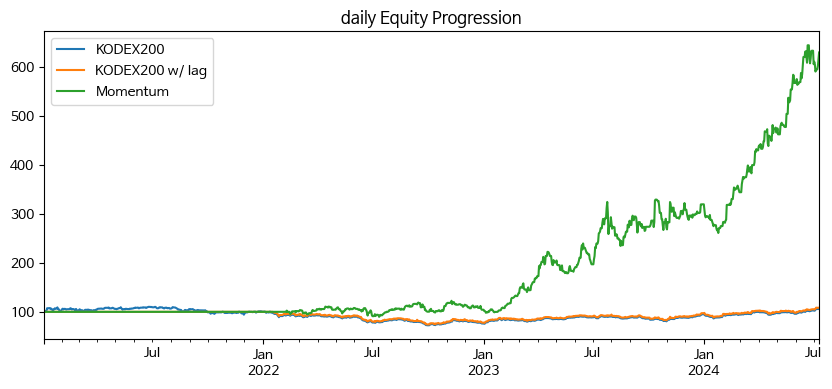

In [73]:
bm.run(figsize=(10,4), metrics=metrics2)

## testin ends

## KOSPI 200

In [23]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [24]:
lags = dict(lookback=12, lag=12)

In [25]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200
RunOnce selected


In [26]:
select = 'Momentum'
kwargs_build = dict(
    name=select, select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [27]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=select, select =select
))
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, Momentum, K-ratio


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.33s/it]

Returning stats


,KODEX200,Momentum,K-ratio
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.023295,0.68841,0.223438
monthly_vol,0.173711,0.432442,0.262307
monthly_sharpe,0.219454,1.428833,0.902308
max_drawdown,-0.257394,-0.276901,-0.229503
avg_drawdown,-0.039862,-0.05712,-0.043621
avg_drawdown_days,98.222222,17.581395,28.321429


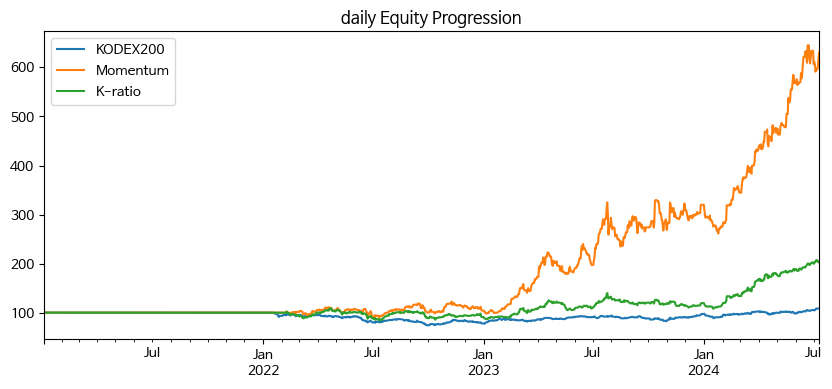

In [28]:
bm.run(figsize=(10,4), metrics=metrics2)

## ETF

In [29]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [30]:
lags = dict(lookback=12, lag=0)

In [31]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200
RunOnce selected


### Weights

In [32]:
bm.build(
    name = 'COMB1: Eqaully',
    freq = 'Y', select = 'all', weigh = 'equally',
    **lags # added to start backtest on same date with momentum
)

In [33]:
bm.build(
    name = 'COMB2: ERC',
    freq = 'Y', select = 'all', weigh = 'ERC', 
    **lags
)

In [34]:
bm.build(    
    name = 'COMB3: InvVol',
    freq = 'Y', select = 'all', weigh = 'InvVol', 
    **lags
)

Backtesting 4 strategies: KODEX200, COMB1: Eqaully, COMB2: ERC, COMB3: InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


Returning stats


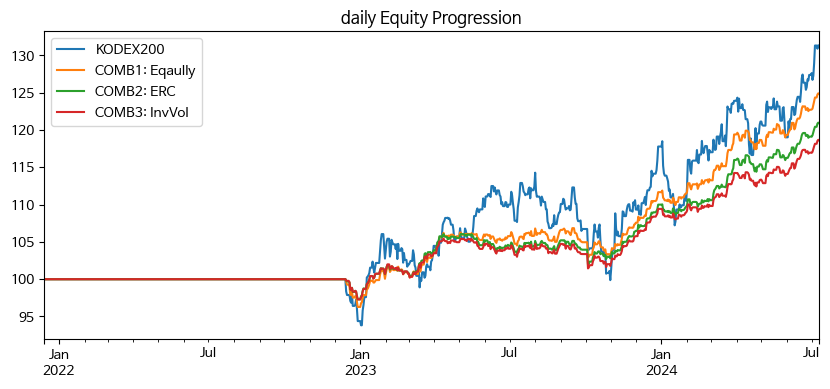

In [35]:
_ = bm.run(figsize=(10,4))

In [36]:
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

,COMB1: Eqaully,COMB2: ERC,COMB3: InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
cagr,0.090121,0.076648,0.068648,0.111805
monthly_vol,0.066052,0.05665,0.055714,0.141305
monthly_sharpe,1.336255,1.328341,1.215825,0.816758
max_drawdown,-0.037245,-0.038813,-0.038013,-0.126072
avg_drawdown,-0.00824,-0.007614,-0.00727,-0.02702
avg_drawdown_days,13.558824,17.615385,18.48,20.75


### Freq

In [41]:
kwargs_build = dict(
    select = 'all', **lags,
    weigh = 'ERC', 
    #weigh = 'Equally'
)

kwa_list = [{'name':f'freq {x}', 'freq':x} for x in ['M', 'Q', 'Y']]

bm.build_batch(*kwa_list, **kwargs_build)

In [42]:
bm.portfolios

0) KODEX200
1) COMB1: Eqaully
2) COMB2: ERC
3) COMB3: InvVol
4) freq M
5) freq Q
6) freq Y

In [43]:
pf_list = [4,5,6]
_ = bm.run(pf_list, plot=False)
bm.get_stats(sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 3 strategies: freq M, freq Q, freq Y


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.97it/s]

Returning stats


,freq Q,freq M,freq Y
start,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10
cagr,0.079483,0.080227,0.076648
monthly_vol,0.057267,0.05818,0.05665
monthly_sharpe,1.360582,1.351968,1.328341
max_drawdown,-0.037223,-0.037739,-0.038813
avg_drawdown,-0.006954,-0.00693,-0.007614
avg_drawdown_days,15.655172,15.655172,17.615385


In [40]:
df = bm.get_security_weights(2).rename_axis(None)
df.columns = [f'{bm.asset_names[x]} ({x})' for x in df.columns]
df.T

freq Y: weights at transactions returned


,2022-12-14,2024-03-29
KODEX 200 (069500),0.166342,0.166417
KODEX 종합채권(AA-이상)액티브 (273130),0.162736,0.165556
KOSEF 국고채10년 (148070),0.159886,0.158629
KODEX 미국S&P500TR (379800),0.166595,0.166309
ACE KRX금현물 (411060),0.166311,0.165766
KODEX 200미국채혼합 (284430),0.166250,0.166546


# Transaction

## KOSPI200

In [44]:
file_record = 'pf_k200_momentum_240710.csv'

pf_k200 = MomentumPortfolio(df_k200, file_record,
                            path=path_tran, days_in_year=246,
                            asset_names=assetnames_k200)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [45]:
pf_k200.transaction_pipeline()

5 assets selected by Total return from 2023-07-10 to 2024-07-10
Weights of assets determined by ERC.
Net profit: 0
Set save=True to save transaction record


price  transaction  net weights
date       asset                                   
2024-07-10 000150  233500            8    8    0.20
           003230  619000            3    3    0.20
           010120  224500            8    8    0.20
           042700  162400           12   12    0.21
           267260  342000            5    5    0.19

## ETF

In [46]:
file_record = 'pf_etf_static_240710.csv'

pf_etf = StaticPortfolio(df_etf, file_record, 
                         path=path_tran, days_in_year=245)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [47]:
pf_etf.transaction_pipeline()

6 assets from 2023-07-10 to 2024-07-10 prepared for weight analysis
Weights of assets determined by ERC.
Net profit: 0
Set save=True to save transaction record


price  transaction  net weights
date       asset                                   
2024-07-10 069500   39735           21   21    0.08
           148070  114330           16   16    0.18
           273130  112380           24   24    0.27
           284430   13490          118  118    0.16
           379800   17560           88   88    0.16
           411060   15005           93   93    0.14